In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import datetime
import os

In [6]:
# load data
Sentiment_Result = pd.read_pickle("C:/Users/user/Desktop/Chinese_derivative_1229/09_words_and_labels/Sentiment_Analysis_Result_onlyOF.pkl")
Sentiment_Result = Sentiment_Result.rename(columns={'Publication_Date': 'Dates'})

TW50 = pd.read_csv("C:/Users/user/Desktop/Chinese_derivative_1229/0050_TW.csv")

In [7]:
# 填補股價缺少資料
TW50_prune = TW50.drop(["High", "Low", "Open", "Volume", 'Close'], axis=1)
TW50_dict = {}

for i, j in zip(TW50_prune['Date'], TW50_prune['Adj Close']): 
    date_obj = datetime.datetime.strptime(i, '%Y-%m-%d')
    TW50_dict[date_obj] = j

In [8]:
TW50_dict_filled = TW50_dict.copy()
start_date = datetime.date(2022,10, 29)
end_date = datetime.date(2022,12, 15)

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + datetime.timedelta(n)

for single_date in daterange(start_date, end_date):
    query_date = single_date.strftime("%Y-%m-%d")
    query_date = datetime.datetime.strptime(query_date, '%Y-%m-%d')
    if query_date not in TW50_dict_filled.keys(): # missing value
        i = -1
        before = query_date + datetime.timedelta(-1)
        while before not in TW50_dict_filled.keys(): 
            before += datetime.timedelta(-1)
        i = 1
        after = query_date + datetime.timedelta(1)
        while after not in TW50_dict_filled.keys(): 
            after += datetime.timedelta(1)
        before_val = TW50_dict_filled[before]
        after_val = TW50_dict_filled[after]
        mean_val = (before_val+after_val)/2
        TW50_dict_filled[query_date] = mean_val

In [9]:
dates = list(TW50_dict_filled.keys())
close = list(TW50_dict_filled.values())

TW50_df_pivot = pd.DataFrame()
TW50_df_pivot['Dates'] = dates
TW50_df_pivot['Close'] = close
TW50_df_pivot = TW50_df_pivot.sort_values(by='Dates').reset_index(drop=True)
TW50_df_pivot = TW50_df_pivot.query('"2022-10-28" <= Dates <= "2022-12-15"') # 多一天為了計算delta

In [10]:
print("Sentiment:")
print("start: ", Sentiment_Result.Dates.min(), ", End: ", Sentiment_Result.Dates.max())
print('Size: ', len(Sentiment_Result['Sentiment_Score']), '\n')

print("TW50:")
print("start: ", TW50_df_pivot.Dates.min(), ", End: ", TW50_df_pivot.Dates.max())
print('Size: ', len(TW50_df_pivot['Dates']), )

Sentiment:
start:  2022-10-29 00:00:00 , End:  2022-12-15 00:00:00
Size:  48 

TW50:
start:  2022-10-28 00:00:00 , End:  2022-12-15 00:00:00
Size:  49


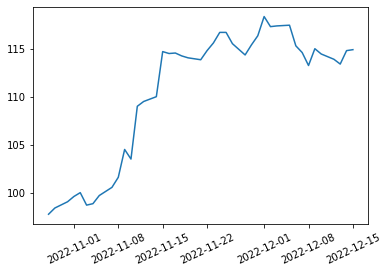

In [11]:
plt.plot(TW50_df_pivot['Dates'], TW50_df_pivot['Close'])
plt.xticks(rotation=25)
plt.show()

In [12]:
TW50_df = TW50_df_pivot.copy()
TW50_df = TW50_df.reset_index(drop=True)
TW50_df['Yesterday'] = TW50_df['Close'].shift(1)
TW50_df['Delta'] = TW50_df['Close'] - TW50_df['Yesterday']
TW50_df = TW50_df.query('"2022-10-29" <= Dates') # 計算完後刪去多的一天
Merge_df = TW50_df.merge(Sentiment_Result, on='Dates')
Merge_df = Merge_df.drop(columns=['Yesterday', 'Tokens', 'token_num'])
Merge_df

KeyError: "['Tokens'] not found in axis"

# Granger Causality

Granger Causality test is used to determine **whether or not one time series is useful for forecasting another.**

This test uses the following null and alternative hypotheses:

> **Null Hypothesis (H0): Time series x does not Granger-cause time series y**

> **Alternative Hypothesis (HA): Time series x Granger-causes time series y**


If the p-value is less than a certain significance level (i.e. α = .05), then we can reject the null hypothesis and conclude that we have sufficient evidence to say that time series x Granger-causes time series y.

In [ ]:
# Perform Granger-Causality test on TW50 index directly! (alpha=0.05)
from statsmodels.tsa.stattools import grangercausalitytests

# 1. Test if it have the predictive power on TW50
print("Adjusted Close:")
lag_list1 = []
p_list1 = []
for lag in range(1, 10): 
    res1 = grangercausalitytests(Merge_df[['Close', 'Sentiment_Score']], maxlag=[lag]) 
    lag_list1.append(lag)
    p_list1.append(res1[lag][0]['ssr_ftest'][1]) # parameter: max_lag/0/f test/p_value

Adj_df = pd.DataFrame({'max_lag':lag_list1, 'p_value':p_list1})
Adj_df = Adj_df.sort_values(by='p_value', ascending=True).reset_index(drop=True)
Adj_df

In [13]:
# Perform Granger-Causality test on TW50 index directly! (alpha=0.05)
from statsmodels.tsa.stattools import grangercausalitytests

# 1. Test if it have the predictive power on TW50
print("Adjusted Close:")
lag_list1 = []
p_list1 = []
for lag in range(1, 10): 
    res1 = grangercausalitytests(Merge_df[['Delta', 'Sentiment_Score']], maxlag=[lag]) 
    lag_list1.append(lag)
    p_list1.append(res1[lag][0]['ssr_ftest'][1]) # parameter: max_lag/0/f test/p_value

Adj_df = pd.DataFrame({'max_lag':lag_list1, 'p_value':p_list1})
Adj_df = Adj_df.sort_values(by='p_value', ascending=True).reset_index(drop=True)
Adj_df

Adjusted Close:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0167  , p=0.8977  , df_denom=44, df_num=1
ssr based chi2 test:   chi2=0.0179  , p=0.8937  , df=1
likelihood ratio test: chi2=0.0179  , p=0.8937  , df=1
parameter F test:         F=0.0167  , p=0.8977  , df_denom=44, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8330  , p=0.4420  , df_denom=41, df_num=2
ssr based chi2 test:   chi2=1.8692  , p=0.3927  , df=2
likelihood ratio test: chi2=1.8322  , p=0.4001  , df=2
parameter F test:         F=0.8330  , p=0.4420  , df_denom=41, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9700  , p=0.1349  , df_denom=38, df_num=3
ssr based chi2 test:   chi2=6.9988  , p=0.0719  , df=3
likelihood ratio test: chi2=6.5051  , p=0.0895  , df=3
parameter F test:         F=1.9700  , p=0.1349  , df_denom=38, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2856  , 

,max_lag,p_value
0,3,0.134870
1,6,0.231615
2,5,0.276946
3,7,0.284474
4,4,0.294396
5,9,0.405505
6,8,0.431931
7,2,0.441961
8,1,0.897697
